In [1]:
from lida import Manager, TextGenerationConfig , llm  
import pandas as pd 

In [37]:
lida = Manager(text_gen = llm("openai", api_key=None)) # !! api key
textgen_config = TextGenerationConfig(n=1, temperature=0.5, model="gpt-3.5-turbo-0301", use_cache=True)

# file_url="https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv"
file_url = "https://raw.githubusercontent.com/prasertcbs/basic-dataset/master/netflix_titles.csv"
file_name = file_url.split("/")[-1]
summary = lida.summarize(file_url, summary_method="llm", textgen_config=textgen_config)  


In [35]:
import json
import logging
from lida.utils import clean_code_snippet
from llmx import TextGenerator
from lida.datamodel import Persona, Summary, TextGenerationConfig
from typing import Dict

logger = logging.getLogger("lida")

planner_system_message = """
You are a highly skilled data scientist that can come up with a detailed on how to clean data or test for data quality issues for a given dataset column. For each column, you will be given properties of the column and your task is to return a list of data cleaning tests that should be run on the column. For each test, you should output a rationale (i.e. why this test is relevant given the properties of the column), a code snippet that can be used to run the test, a severity score (scale of 1 low - 10 high) and a test name. The severity score should be based on the likelihood of the issue occurring and the impact of the issue. The severity score should be a number between 1 and 10. The test name should be a short description of the test. ONLY INCLUDE IMPORTANT ISSUES. THE RATIONALE MUST CONTAIN REASONS FOR WHY THE TEST IS IMPORTANT AND JUSTIFY THE SEVERITY SCORE.

Your OUTPUT MUST BE ONLY A CODE SNIPPET of a PERFECTLY FORMATTED JSON LIST in the format:
```[{"rationale": " ...", "code": "import xxx\n ...", "test": " ..." , "severity": x}, ...]``` 
 """




class DataCleaner():
    """Methods for data cleaning"""

    def __init__(self) -> None:
        pass

    def get_column_plan(self, column_properties: Dict,textgen_config: TextGenerationConfig, text_gen: TextGenerator, n_plans: int = 4) -> dict:
        """Generate a test plan for cleaning a column given its properties"""
        
        messages = [
        {"role": "system", "content": planner_system_message},
        {"role": "assistant",
         "content":
         f"The dataset column properties are {column_properties}.\n Now generate a data cleaning plan with a maximum of {n_plans} tests."}] 
        response = text_gen.generate(messages, textgen_config)
        plan = []
        try:
            plan = [json.loads(x["content"]) for x in response.text]
        except Exception as e: 
            print("Error parsing json", str(e), response.text[0]["content"])
        return plan
    
    def plan(self, summary:Summary,textgen_config: TextGenerationConfig, text_gen: TextGenerator,  n_plans=4):

        if isinstance(summary, dict):
            summary = Summary(**summary) 

        all_plans = []
        for column in summary.fields: 
            plan = self.get_column_plan(column, textgen_config, text_gen, n_plans)
            if len(plan) > 0:
                plan = plan[0]
                for p in plan:
                    p["column"] = column
                all_plans.extend(plan)
        return all_plans
 

In [36]:
cleaner = DataCleaner()
plan = cleaner.plan(summary, textgen_config, lida.text_gen, n_plans=4)

Error parsing json Invalid \escape: line 3 column 442 (char 1364) [{"rationale": "The 'cast' column is a string type column that contains the names of actors in a movie or TV show. It is important to check for missing values in this column as it could affect the analysis of the data. If there are missing values, it may not be possible to determine the cast of a movie or TV show, which could impact the analysis of the data. ", "code": "df['cast'].isnull().sum()", "test": "Check for missing values", "severity": 6},
{"rationale": "The 'cast' column is a string type column that contains the names of actors in a movie or TV show. It is important to check for duplicate values in this column as it could affect the analysis of the data. If there are duplicate values, it may skew the results of the analysis as it will appear that certain actors are more prevalent than they actually are. ", "code": "df['cast'].duplicated().sum()", "test": "Check for duplicate values", "severity": 5},
{"rationale

In [39]:
df = pd.DataFrame(plan)
df.to_csv(f"data/{file_name}_plans.csv")
df.head(5)

,rationale,code,test,severity,column
0,The 'show_id' column is an identifier column a...,duplicates = df.duplicated(subset=['show_id'])...,Check for duplicate values in 'show_id' column,7,"{'column': 'show_id', 'properties': {'dtype': ..."
1,The 'show_id' column should not contain missin...,null_count = df['show_id'].isnull().sum()\nif ...,Check for missing or null values in 'show_id' ...,8,"{'column': 'show_id', 'properties': {'dtype': ..."
2,The 'show_id' column should only contain numer...,non_numeric_count = df['show_id'].apply(lambda...,Check for non-numeric values in 'show_id' column,6,"{'column': 'show_id', 'properties': {'dtype': ..."
3,The 'show_id' column should not contain outlie...,q1 = df['show_id'].quantile(0.25)\nq3 = df['sh...,Check for outliers in 'show_id' column,5,"{'column': 'show_id', 'properties': {'dtype': ..."
4,Missing values may cause errors or inaccuracie...,df['type'].isnull().sum(),Check for missing values,3,"{'column': 'type', 'properties': {'dtype': 'ca..."


<Axes: xlabel='severity', ylabel='Count'>

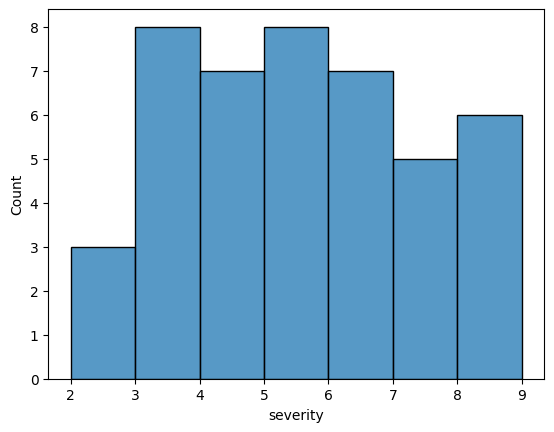

In [41]:
import seaborn as sns 

sns.histplot(df["severity"])

<Axes: ylabel='test'>

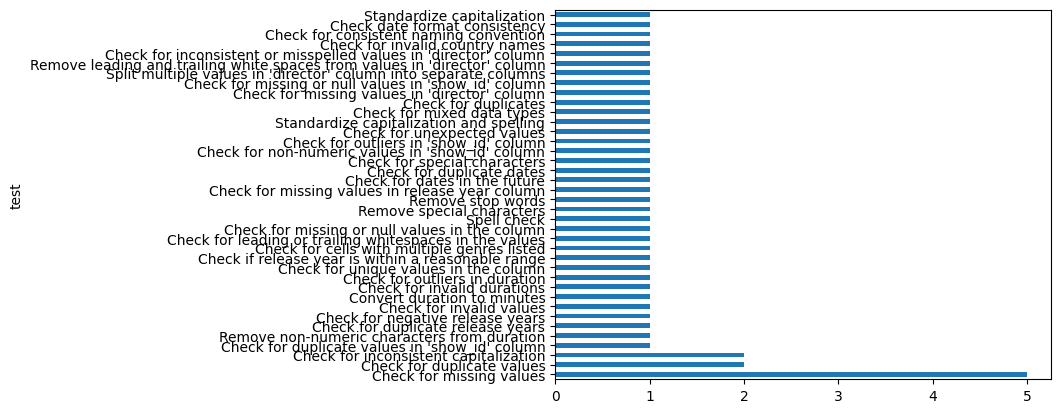

In [42]:
# plot df.test.value_counts()  
df.test.value_counts().plot(kind="barh")